In [52]:
%pip install xgboost matplotlib

Note: you may need to restart the kernel to use updated packages.


In [53]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings

In [54]:
warnings.filterwarnings("ignore")

In [55]:
df = pd.read_csv("cleaned_breast_cancer_data.csv")

df.head()

,Age,differentiate,Tumor Size,Survival Months,Node Positive Ratio,T Stage Encoded,M Stage Encoded,N Stage Encoded,Estrogen Status Encoded,Progesterone Status Encoded,Survival More Than 6 Years
0,68,3,4,60,0.041667,0.0,1,0.0,1,1,0
1,50,2,35,62,0.357143,1.0,1,1.0,1,1,0
2,58,2,63,75,0.500000,2.0,1,2.0,1,1,1
3,58,3,18,84,0.500000,0.0,1,0.0,1,1,1
4,47,3,41,50,0.333333,1.0,1,0.0,1,1,0


In [56]:
X = df.drop(columns=["Survival More Than 6 Years", "Survival Months"])
y = df["Survival Months"]

[0.08512621 0.08965654 0.10572889 0.10856219 0.07021804 0.12809627
 0.14736243 0.12382723 0.14142221]


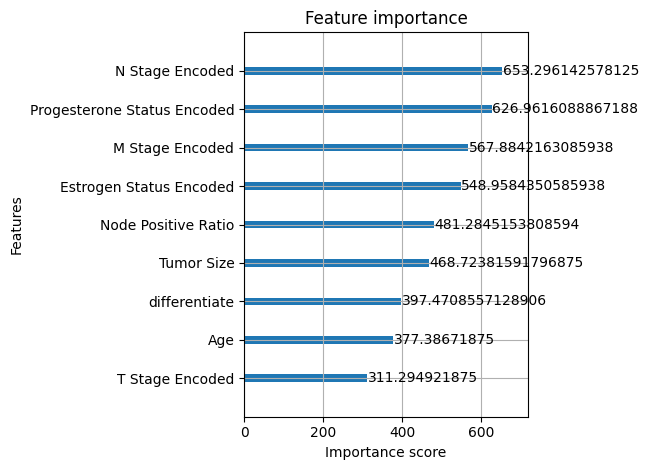

In [57]:
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

model = xgb.XGBRegressor()
model.fit(X_train, y_train)

print(model.feature_importances_)

xgb.plot_importance(model, importance_type="gain")
plt.tight_layout()
plt.show()

In [58]:
importance_dict = model.get_booster().get_score(importance_type="gain")
keys = list(importance_dict.keys())
values = list(importance_dict.values())

importance_df = pd.DataFrame(
    {
        "feature": list(importance_dict.keys()),
        "importance": list(importance_dict.values()),
    }
).sort_values(by="importance", ascending=False)

print(importance_df)


                       feature  importance
6              N Stage Encoded  653.296143
8  Progesterone Status Encoded  626.961609
5              M Stage Encoded  567.884216
7      Estrogen Status Encoded  548.958435
3          Node Positive Ratio  481.284515
2                   Tumor Size  468.723816
1                differentiate  397.470856
0                          Age  377.386719
4              T Stage Encoded  311.294922


In [59]:
import numpy as np
from numpy import sort
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score, root_mean_squared_error
from xgboost import XGBRegressor

model = XGBRegressor()
model.fit(X_train, y_train)

thresholds = sort(model.feature_importances_)

for thresh in thresholds:
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)

    selected_features = X_train.columns[selection.get_support()]

    selection_model = XGBRegressor()
    selection_model.fit(select_X_train, y_train)

    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)

    print(
        "Thresh=%.3f, n=%d, R²: %.3f, RMSE: %.3f"
        % (thresh, select_X_train.shape[1], r2, rmse)
    )
    print("Selected Features:", list(selected_features))
    print("-" * 60)


Thresh=0.070, n=9, R²: -0.202, RMSE: 25.327
Selected Features: ['Age', 'differentiate', 'Tumor Size', 'Node Positive Ratio', 'T Stage Encoded', 'M Stage Encoded', 'N Stage Encoded', 'Estrogen Status Encoded', 'Progesterone Status Encoded']
------------------------------------------------------------
Thresh=0.085, n=8, R²: -0.200, RMSE: 25.301
Selected Features: ['Age', 'differentiate', 'Tumor Size', 'Node Positive Ratio', 'M Stage Encoded', 'N Stage Encoded', 'Estrogen Status Encoded', 'Progesterone Status Encoded']
------------------------------------------------------------
Thresh=0.090, n=7, R²: -0.138, RMSE: 24.641
Selected Features: ['differentiate', 'Tumor Size', 'Node Positive Ratio', 'M Stage Encoded', 'N Stage Encoded', 'Estrogen Status Encoded', 'Progesterone Status Encoded']
------------------------------------------------------------
Thresh=0.106, n=6, R²: -0.129, RMSE: 24.545
Selected Features: ['Tumor Size', 'Node Positive Ratio', 'M Stage Encoded', 'N Stage Encoded', 'Es